In [26]:

import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from nltk.corpus import stopwords
import sys
# sys.path.append(r"C:\Users\Laptop Land\AppData\Roaming\Python\Python311\site-packages")

# from xgboost import XGBClassifier

from sklearn.multiclass import OneVsRestClassifier


In [27]:

df = pd.read_csv('Equal.csv', encoding='latin-1')

min_count = df['Sentiment'].value_counts().min()
df = df[df['Sentiment'] != 'neutral']

df = df.groupby('Sentiment').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

print(df['Sentiment'].value_counts())


Sentiment
negative    25001
positive    25001
Name: count, dtype: int64


C:\Users\Laptop Land\AppData\Local\Temp\ipykernel_14292\1120770292.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Sentiment').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [28]:

negation_words = {'no', 'not', 'nor', 'never'}
stop_words = set(stopwords.words('english')) - negation_words
def clean_text(text):
    text = str(text).lower()                             
    text = re.sub(r'[^a-z\s]', '', text)             
    words = text.split()                                 # تقسيم النص لكلمات
    words = [w for w in words if w not in stop_words]    # حذف الكلمات الشائعة
    cleaned = ' '.join(words)
    # print(f"Original: {text} → Cleaned: {cleaned}")
    return cleaned

df = df.sample(frac=1).reset_index(drop=True)
df['Review'] = df['Review'].fillna('').apply(clean_text)
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce').fillna(0).astype(int)


In [29]:
X = df[['Review', 'Rate']]
# Explicitly map 'positive' to 1 and 'negative' to 0 for binary classification
y = df['Sentiment'].map({'positive': 1, 'negative': 0})

# Verify the number of classes and some values
print("Value counts for y:")
print(y.value_counts())
print("\nFirst 5 values of y:")
print(y.head())
# classes = ['positive', 'negative']  # تحديد الفئات بشكل صريح

# # تحويل القيم إلى تمثيل ثنائي
# y_bin = label_binarize(y, classes=classes)

# # عدد الفئات
# n_classes = y_bin.shape[1]
# print("Number of classes:", n_classes)

# # طباعة y_bin
# print("Binary representation of y:")
# print(y_bin)

Value counts for y:
Sentiment
0    25001
1    25001
Name: count, dtype: int64

First 5 values of y:
0    0
1    1
2    1
3    0
4    1
Name: Sentiment, dtype: int64


In [30]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Use 'y' and add stratify
)


In [31]:

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1,2)), 'Review'),
    ('scaler', StandardScaler(), ['Rate'])
])


In [32]:

model = Pipeline([
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(max_depth=5, random_state=42)) # Removed OneVsRestClassifier
])
# Pipeline([
#     ('pre', preprocessor),
#     ('clf', OneVsRestClassifier( DecisionTreeClassifier(max_depth=5, random_state=42)))
#         # RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)))
# ])

xgb_model = Pipeline([
    ('pre', preprocessor),  # نفس المعالجة المسبقة المستخدمة
    ('clf', OneVsRestClassifier(XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        random_state=42
    )))
  ])

model.fit(X_train, y_train)
y_pred_dt = model.predict(X_test)

sentiment_mapping = {1: 'positive', 0: 'negative'}
y_pred_labels_dt = pd.Series(y_pred_dt).map(sentiment_mapping)
print("Decision Tree Predictions (first 5):")
print(y_pred_labels_dt.head())
print("\nUnique values in Decision Tree predictions:", y_pred_labels_dt.unique())


Decision Tree Predictions (first 5):
0    positive
1    negative
2    positive
3    negative
4    negative
dtype: object

Unique values in Decision Tree predictions: ['positive' 'negative']


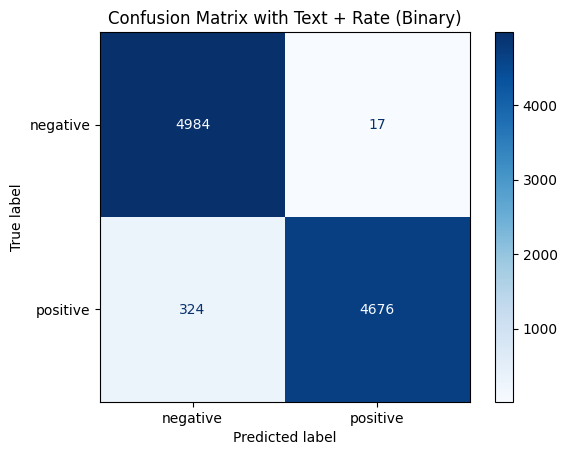

Confusion Matrix:
[[4984   17]
 [ 324 4676]]


In [35]:
# Ensure y_test is a 1D array (this line was already in the previous full code block)
y_true_binary = y_test.flatten() if y_test.ndim > 1 else y_test

# Use the numerical predictions (y_pred_dt) directly for the confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_dt, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix with Text + Rate (Binary)")
plt.show()
print("Confusion Matrix:")
print(cm)

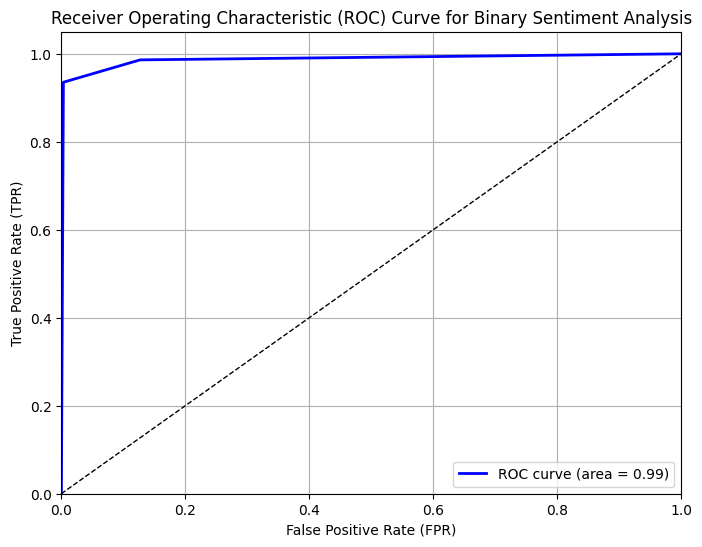

Area Under the Curve (AUC): 0.99


In [38]:

# Ensure y_test is a 1D array (as defined in previous steps)
y_true_binary = y_test.flatten() if y_test.ndim > 1 else y_test

# Get the probability scores for the positive class (class 1) from the Decision Tree model
# model_dt.predict_proba(X_test) returns probabilities for [negative class, positive class]
y_proba_dt = model.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_true_binary, y_proba_dt)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

# Plot the ROC curve for the positive class
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f"ROC curve (area = {roc_auc:.2f})") # Changed label for binary classification

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve for Binary Sentiment Analysis") # Updated title
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Area Under the Curve (AUC): {roc_auc:.2f}")

In [40]:

# Your preprocessor definition
preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1,2)), 'Review'),
    ('scaler', MinMaxScaler(), ['Rate'])
])

# Define your models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
    "Naïve Bayes": MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42)
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

# Loop through each model for training and evaluation
for name, clf in models.items():
    # Create a pipeline without OneVsRestClassifier for binary classification
    model = Pipeline([
        ('pre', preprocessor),
        ('clf', clf) # Directly use the classifier for binary
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) # y_pred will now be 0s and 1s directly

    # Append results using numerical y_test and y_pred
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    # For binary classification, 'weighted' average is often robust
    results["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
    results["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
    results["F1-score"].append(f1_score(y_test, y_pred, average='weighted'))

results_df = pd.DataFrame(results)
print(results_df)

           Model  Accuracy  Precision    Recall  F1-score
0  Random Forest  0.966203   0.967956  0.966203  0.966172
1    Naïve Bayes  0.935006   0.935546  0.935006  0.934986
2  Decision Tree  0.965903   0.967666  0.965903  0.965871


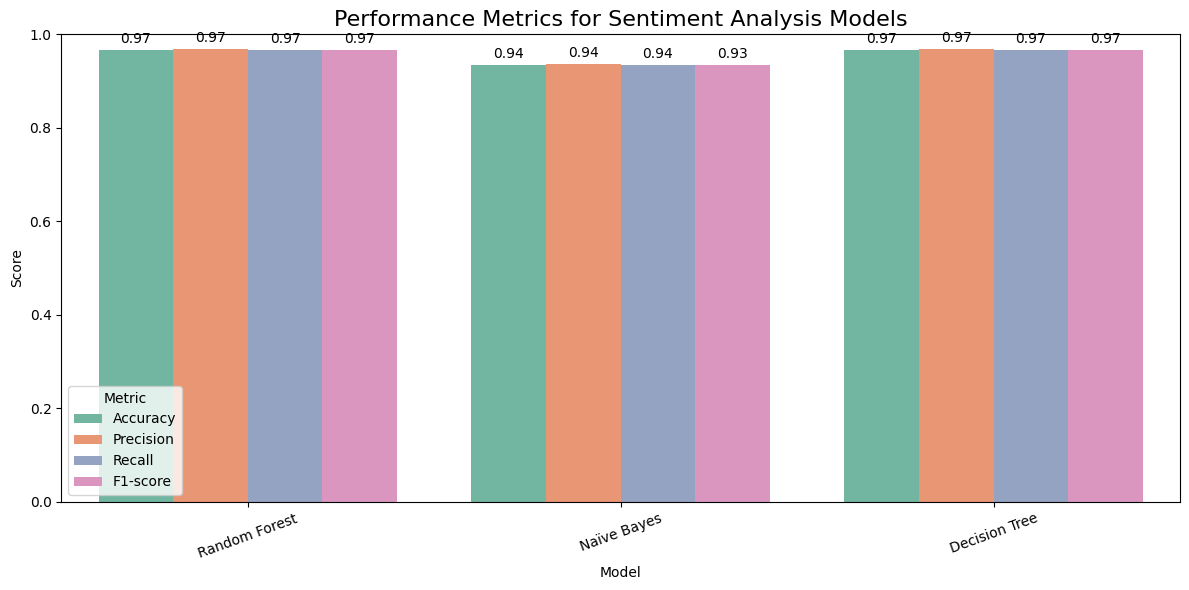

In [41]:
# تحويل النتائج إلى شكل Long Format
results_long = pd.melt(results_df, id_vars=["Model"], 
                       value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'],
                       var_name="Metric", value_name="Score")

# رسم المخطط الموحد
plt.figure(figsize=(12, 6))
sns.barplot(data=results_long, x="Model", y="Score", hue="Metric", palette="Set2")

# تحسين العرض
plt.title("Performance Metrics for Sentiment Analysis Models", fontsize=16)
plt.ylim(0, 1)
plt.xticks(rotation=20)

# عرض القيم على الأعمدة
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.legend(title="Metric")
plt.tight_layout()
plt.show()